In [9]:
push!(LOAD_PATH, "/Users/reuben/backtesting")
using Backtesting
using Plots

In [10]:
ENV["ALPHA_VANTAGE_API_KEY"] = "UETDE6D6M3TS37ZG"

"UETDE6D6M3TS37ZG"

In [11]:
ta = daily_timeseries("SPY")

5032×5 TimeSeries.TimeArray{Any,2,Dates.Date,Array{Any,2}} 2000-05-11 to 2020-05-12
│            │ open     │ high     │ low      │ close    │ volume    │
├────────────┼──────────┼──────────┼──────────┼──────────┼───────────┤
│ 2000-05-11 │ 140.125  │ 141.5    │ 139.125  │ 141.2812 │ 7091100   │
│ 2000-05-12 │ 141.8125 │ 143.4687 │ 141.625  │ 142.8125 │ 5960800   │
│ 2000-05-15 │ 142.75   │ 145.6093 │ 142.0    │ 145.2812 │ 4441300   │
│ 2000-05-16 │ 146.5625 │ 147.7187 │ 145.3125 │ 146.6875 │ 8192200   │
│ 2000-05-17 │ 145.6875 │ 146.1875 │ 144.4687 │ 145.1562 │ 5907200   │
│ 2000-05-18 │ 145.625  │ 146.3125 │ 143.375  │ 143.375  │ 4325600   │
│ 2000-05-19 │ 142.5625 │ 143.2343 │ 140.4062 │ 141.125  │ 6518400   │
│ 2000-05-22 │ 141.25   │ 141.4687 │ 137.0    │ 140.0625 │ 10839400  │
│ 2000-05-23 │ 140.4375 │ 140.8125 │ 137.5625 │ 138.0    │ 7979200   │
│ 2000-05-24 │ 138.0    │ 140.6875 │ 136.5    │ 140.25   │ 11081500  │
│ 2000-05-25 │ 140.6875 │ 141.8125 │ 137.7187 │ 137.8437 │ 82789

In [12]:
function get_returns(vec::Vector, n::Int=1)
    v1 = vec[1:end-n]
    v2 = vec[1+n:end]
    out = Array{Float64,1}()
    for i=1:n:length(v1)
        a=v1[i]
        b=v2[i]
        push!(out, (b-a)/a)
    end
    out
end

get_returns (generic function with 2 methods)

In [13]:
# daily returns
v = ta[:close] |> values |> get_returns;

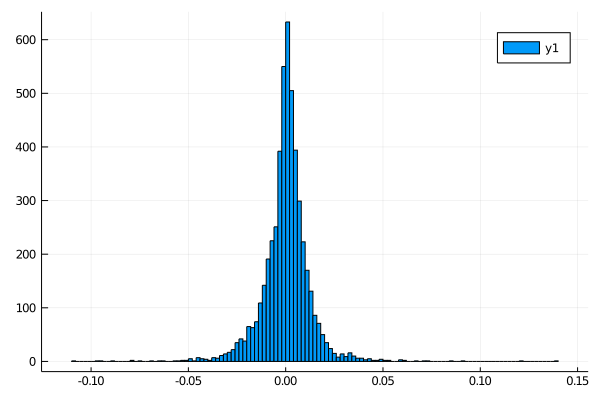

In [14]:
histogram(v)

In [15]:
# 3 day returns
v3_1 = get_returns(values(ta[:close]), 3)
v3_2 = get_returns(values(ta[:close])[2:end], 3)
v3_3 = get_returns(values(ta[:close])[3:end], 3);

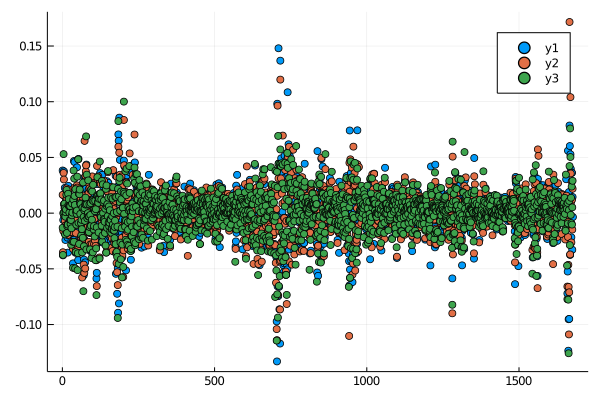

In [16]:
scatter(v3_1)
scatter!(v3_2)
scatter!(v3_3)

In [17]:
# Hill estimator...very close to MLE
function Hill(vec::Vector, gamma::Float64 = .01, tail=:right)
    ii = tail == :left ? -1 : 1
    v = filter(x->x>gamma,ii*vec) |> sort |> reverse
    k = length(v)-1
    log_v = map(log, v[1:end-1])
    llv = log(last(v))
    d = [x - llv for x in log_v] |> sum
    k / d
end

Hill (generic function with 3 methods)

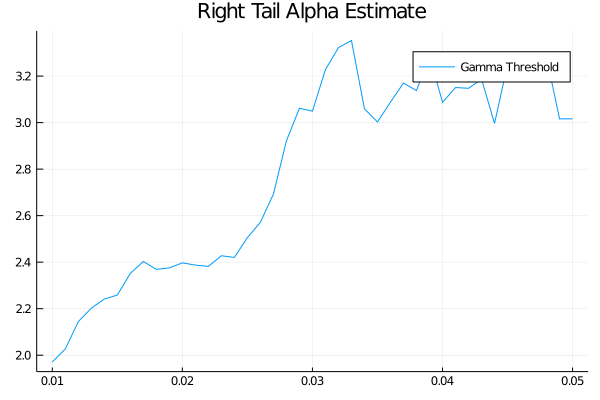

In [24]:
# have to set gamma at some threshsold for tail
y =[Hill(v, gamma, :right) for gamma in .01:.001:.05]
x = [gamma for gamma in .01:.001:.05]
plot(x,y, title = "Right Tail Alpha Estimate", label = "Gamma Threshold")

In [25]:
png("Right Tail Gamma")

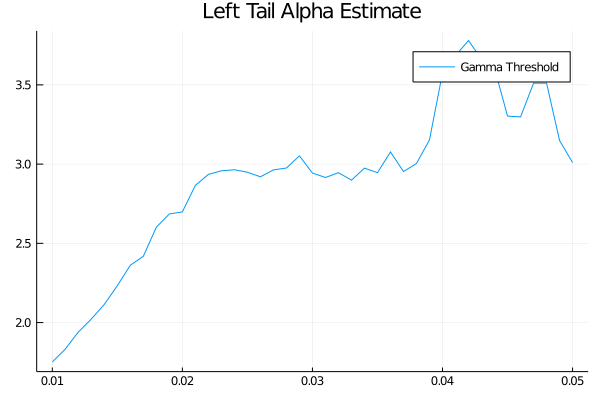

In [26]:
# left tail
y =[Hill(v, gamma, :left) for gamma in .01:.001:.05]
x = [gamma for gamma in .01:.001:.05]
plot(x,y, title = "Left Tail Alpha Estimate", label = "Gamma Threshold")

In [27]:
png("Left Tail Gamma")

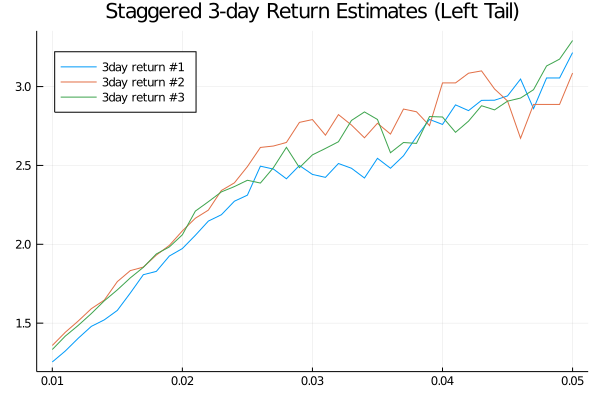

In [101]:
y3s = map([v3_1, v3_2, v3_3]) do v
    [Hill(v, gamma, :left) for gamma in 0.01:0.001:0.05]
end
x = [gamma for gamma in 0.01:0.001:0.05]
p = plot(title="Staggered 3-day Return Estimates (Left Tail)")
for (i,y3) in enumerate(y3s)
    plot!(p, x, y3, label = string("3day return #",i), legend = :topleft)
end
p

In [102]:
png("3day Left Tail v gamma")

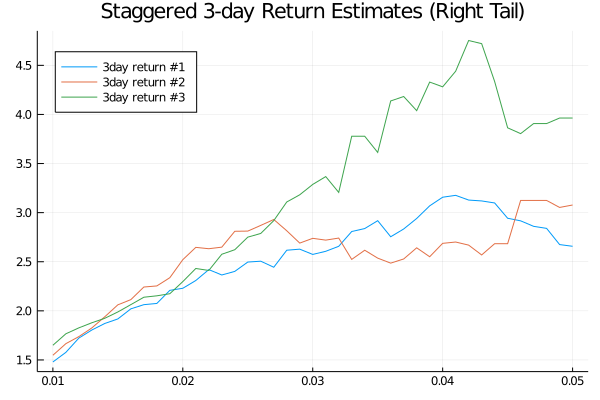

In [99]:
y3s = map([v3_1, v3_2, v3_3]) do v
    [Hill(v, gamma, :right) for gamma in 0.01:0.001:0.05]
end
x = [gamma for gamma in 0.01:0.001:0.05]
p = plot(title="Staggered 3-day Return Estimates (Right Tail)")
for (i,y3) in enumerate(y3s)
    plot!(p, x, y3, label = string("3day return #",i), legend = :topleft)
end
p

In [100]:
png("3day Right Tail v gamma")

In [50]:
# from Taleb: https://arxiv.org/pdf/1908.02347.pdf
function l_scale(C_m, K, S0, alpha)
    ((alpha - 1)^(1/alpha) * C_m^(1/alpha) * (K-S0)^(1-1/alpha)) / S0
end

l_scale (generic function with 1 method)

In [51]:
# anderson darling --> method to set threshsold gamma for tails
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm
# https://arxiv.org/pdf/cond-mat/0411161.pdf

In [52]:
function Asq(vec, gamma)
    s = filter(x-> x>gamma, vec) |> sort
    n_g = length(s)
    alpha = n_g / sum([log(si/gamma) for si in s])
    z(x) = 1 - (gamma / x) ^ alpha
    
    s_array = []
    for (i, si) in enumerate(s)
        sni = s[n_g-i+1] 
        push!(s_array, (2*i-1) * (log(z(si)) + log(1 - z(sni))))
    end
    
    asq = -n_g - 1 / n_g * sum(s_array)
    (gamma, asq, alpha, n_g)
end
    

Asq (generic function with 1 method)

In [55]:
v

5031-element Array{Float64,1}:
  0.010838667848234495
  0.017286301969365515
  0.009679848459401404
 -0.010439198977417895
 -0.012270919189121873
 -0.015693112467306015
 -0.007528786536758193
 -0.014725568942436412
  0.016304347826086956
 -0.01715721925133681
  0.0011338929526702158
  0.03260869565217391
  0.0021929824561403508
  ⋮
  0.014418489592536254
 -0.004598502003135318
  0.026178560179190007
 -0.009310732921796534
 -0.026473423299366555
  0.002758230489055386
  0.009239341256127251
 -0.0067787134421188645
  0.012066842568161854
  0.016546162402669602
  0.00020517029134182148
 -0.019931623931623878

In [61]:
vv = filter(x-> x>0, -1 * v) |> sort
aa = map(vv[1:end-1]) do v
        Asq(vv, v)
    end
filter!(x->x[4] >= 10, aa)
sort!(aa, by=x-> x[2])

2284-element Array{Tuple{Float64,Float64,Float64,Int64},1}:
 (0.021216120190843603, 0.17628645534398402, 2.9084320554965357, 213)
 (0.021673168617251843, 0.17822071576529197, 2.9349307878437916, 202)
 (0.0217700120747212, 0.18143978192676968, 2.9295747873964224, 199)
 (0.021755438859714968, 0.18256174826362326, 2.9385026528219433, 200)
 (0.0217325988983474, 0.18695823121120725, 2.944062559037605, 201)
 (0.021314521940304185, 0.18879196228451178, 2.9063016296325554, 210)
 (0.021792966815255083, 0.18939144103225658, 2.9238804226300723, 198)
 (0.021877655055225174, 0.19718377620574756, 2.9274037355370046, 196)
 (0.0212305472534268, 0.19718678115887656, 2.9005119760410754, 212)
 (0.02193640022094217, 0.19900337496468978, 2.9355118713716397, 195)
 (0.02309722833260018, 0.19923961344017016, 2.957588893461817, 169)
 (0.021422450728363324, 0.19997891930643164, 2.9071857878414895, 207)
 (0.023325358851674506, 0.2054186376636835, 2.9730400819727385, 165)
 ⋮
 (8.182636445455287e-5, 493.9292530963

In [62]:
function fit_alpha(v::Vector, side = :right, nmin = 10 , verbose=true)
    ii = side == :left ? -1 : 1
    vec = filter(x-> x>0, ii * v) |> sort
    
    aa = map(vec[1:end-1]) do v
        Asq(vec, v)
    end
    
    filter!(x-> x[4]>=nmin, aa) # added to make sure there is enough data for a fit
    
    sort!(aa, by=x->x[2])
    (gamma, asq, alpha, n) = aa[1]
    if verbose
        println("Fitted alpha stats ", side, " side is:")
        println("alpha ------> ", alpha)
        println("gamma ------> ", gamma)
        println("Asq --------> ",asq)
        println("n ----------> ", n)
        println("% of N: ----> ", round(n/length(vec)*100, digits=1),"%")
    end
    aa[1]
end

fit_alpha (generic function with 4 methods)

In [63]:
gamma_up, asq_up, alpha_up, n_up = @time fit_alpha(v, :right, 20)

Fitted alpha stats right side is:
alpha ------> 3.1276550284812763
gamma ------> 0.033663602721738184
Asq --------> 0.11701426799882597
n ----------> 56
% of N: ----> 2.1%
  0.625289 seconds (7.63 M allocations: 322.411 MiB, 7.62% gc time)


(0.033663602721738184, 0.11701426799882597, 3.1276550284812763, 56)

In [64]:
gamma_down, asq_down, alpha_down, n_down = @time fit_alpha(v, :left, 20)

Fitted alpha stats left side is:
alpha ------> 2.9084320554965357
gamma ------> 0.021216120190843603
Asq --------> 0.17628645534398402
n ----------> 213
% of N: ----> 9.3%
  0.371060 seconds (5.31 M allocations: 220.865 MiB, 9.77% gc time)


(0.021216120190843603, 0.17628645534398402, 2.9084320554965357, 213)

In [65]:
function F0(s, gamma,  alpha)
    #s > gamma ? 1 - (gamma/s)^alpha : 0
    s > gamma ? 1 - (gamma/s)^alpha : 0
end

F0 (generic function with 1 method)

In [66]:
function fit_line(gamma, alpha, mx,s=.001)
    i = gamma
    xx = []
    yy = []
    while i < mx
        y = i > gamma ? 1 - (gamma/i)^alpha : 0
        push!(xx, i)
        push!(yy, y)
        i += s
    end
    (xx,yy)
end

fit_line (generic function with 2 methods)

In [67]:
function density_scatter_points(v, gamma, alpha)
    emp_x = []
    emp_y = []
    for i in v
        f = F0(i, gamma, alpha)
        if f != 0
            push!(emp_x, i)
            push!(emp_y, f)
        end
    end
    emp_x, emp_y
end

density_scatter_points (generic function with 1 method)

In [68]:
alpha_up

3.1276550284812763

In [69]:
density_scatter_points(v, gamma_up, alpha_up)[1] |> length

56

In [70]:
length(filter(x->x>0,v))

2704

In [75]:
function density_plot_fit(vec, gamma, alpha, side=:right, title = "")
    v = side == :left ? -1*vec : vec
    xx,yy = fit_line(gamma,  alpha, maximum(v))
    x,y = fit_line(gamma, 2.75, maximum(v))
    emp_x, emp_y = density_scatter_points(v, gamma, alpha)
    plot(xx,yy, label=string("Fit Alpha: ", round(alpha, digits=2)), title = title)
    plot!(x,y, label="Alpha: 2.75")
    scatter!(emp_x, emp_y, markersize=2)
end

density_plot_fit (generic function with 3 methods)

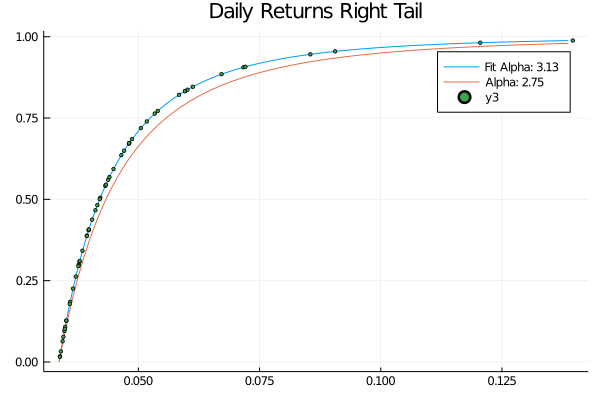

In [79]:
density_plot_fit(v, gamma_up,alpha_up, :right, "Daily Returns Right Tail")

In [80]:
png("Daily Returns Fit Right Tail")

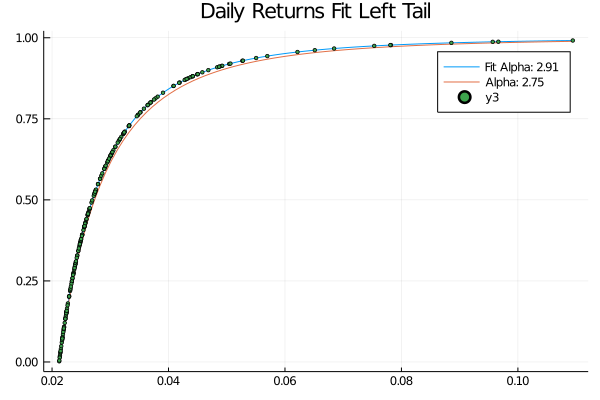

In [81]:
density_plot_fit(v, gamma_down, alpha_down, :left, "Daily Returns Fit Left Tail")

In [82]:
png("Daily Returns Fit Left Tail")

In [579]:
g,_,a,_ = fit_alpha(v3_1,:right)

Fitted alpha stats right side is:
alpha ------> 2.7269141309970664
gamma ------> 0.048672566371681415
Asq --------> 0.1469757036156274
n ----------> 20
% of N: ----> 2.1%


(0.048672566371681415, 0.1469757036156274, 2.7269141309970664, 20)

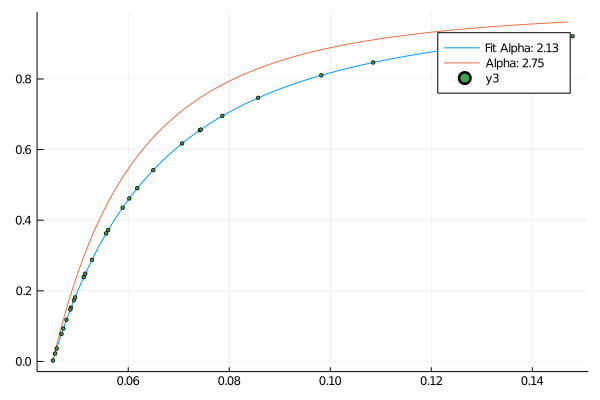

In [596]:
density_plot_fit(v3_1, g, a)

In [588]:
g2,_,a2,_ = fit_alpha(v3_2,:right)

Fitted alpha stats right side is:
alpha ------> 2.686216237168837
gamma ------> 0.02887139107611546
Asq --------> 0.19732173098825
n ----------> 72
% of N: ----> 7.7%


(0.02887139107611546, 0.19732173098825, 2.686216237168837, 72)

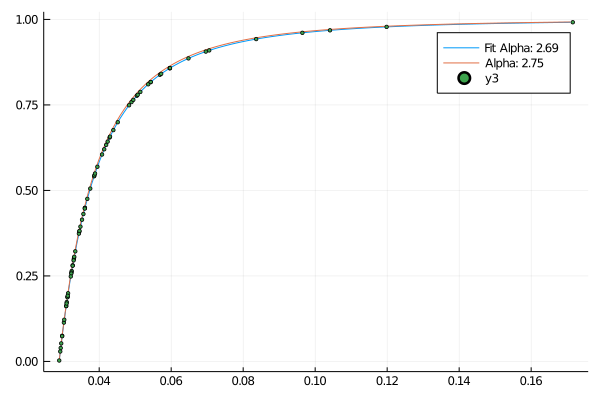

In [598]:
density_plot_fit(v3_2, g2, a2)

In [601]:
g3, _ , a3, _ = fit_alpha(v3_3,:right)

Fitted alpha stats right side is:
alpha ------> 4.073909494041272
gamma ------> 0.0443281938325991
Asq --------> 0.16785479399940684
n ----------> 21
% of N: ----> 2.2%


(0.0443281938325991, 0.16785479399940684, 4.073909494041272, 21)

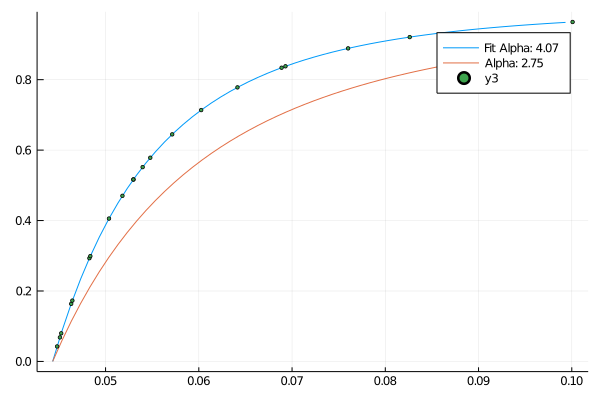

In [602]:
density_plot_fit(v3_3, g3, a3)

In [582]:
fit_alpha(v3_1,:left)

Fitted alpha stats left side is:
alpha ------> 2.8839916067948788
gamma ------> 0.04143605086013458
Asq --------> 0.2210811113596094
n ----------> 50
% of N: ----> 7.0%


(0.04143605086013458, 0.2210811113596094, 2.8839916067948788, 50)

In [583]:
fit_alpha(v3_2,:left)

Fitted alpha stats left side is:
alpha ------> 2.7483873146976117
gamma ------> 0.029056975950231382
Asq --------> 0.19161218306661
n ----------> 100
% of N: ----> 13.6%


(0.029056975950231382, 0.19161218306661, 2.7483873146976117, 100)

In [584]:
fit_alpha(v3_3,:left)

Fitted alpha stats left side is:
alpha ------> 2.5686982272848877
gamma ------> 0.027715355805243362
Asq --------> 0.3542244038704183
n ----------> 106
% of N: ----> 14.7%


(0.027715355805243362, 0.3542244038704183, 2.5686982272848877, 106)

In [87]:
v10right = []
v10left = []
for i=1:9
    v10i = get_returns(values(ta[:close])[i:end], 10)
    aright = [Hill(v10i, gamma, :right) for gamma in 0.01:0.001:0.05]
    aleft = [Hill(v10i, gamma, :left) for gamma in 0.01:0.001:0.05]
    push!(v10right,  aright)
    push!(v10left,  aleft)
end
x = [gamma for gamma in 0.01:0.001:0.05];

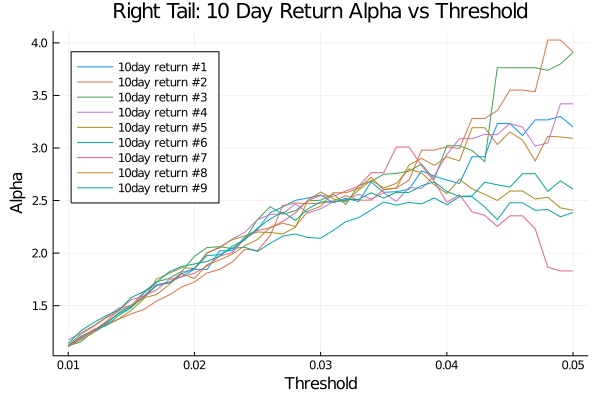

In [96]:
p = plot(title="Right Tail: 10 Day Return Alpha vs Threshold", legend = :topleft, xlabel="Threshold", ylabel = "Alpha")
for (i,y) in enumerate(v10right)
    plot!(p, x, y, label=string("10day return #",i))
end
p

In [97]:
png("10 Day Right Tail vs Alpha")

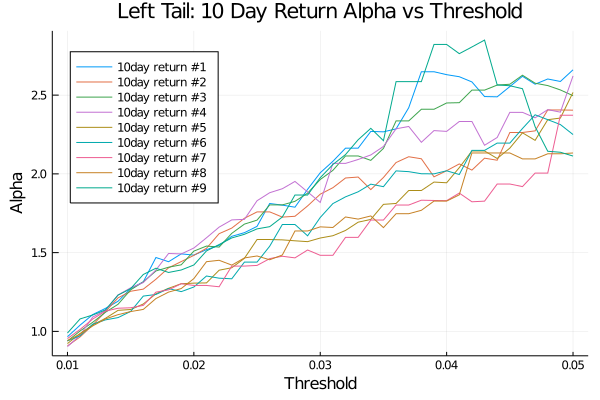

In [94]:
p = plot(title="Left Tail: 10 Day Return Alpha vs Threshold", legend = :topleft, xlabel="Threshold", ylabel = "Alpha")
for (i,y) in enumerate(v10left)
    plot!(p, x, y, label=string("10day return #",i))
end
p

In [95]:
png("10 Day Left Tail vs Alpha")

In [585]:
v10 = get_returns(values(ta[:close]),10);

In [604]:
gg,_,aa,_ = fit_alpha(v10, :right)

Fitted alpha stats right side is:
alpha ------> 3.111572012505357
gamma ------> 0.04890315164287771
Asq --------> 0.13738151992334835
n ----------> 23
% of N: ----> 7.9%


(0.04890315164287771, 0.13738151992334835, 3.111572012505357, 23)

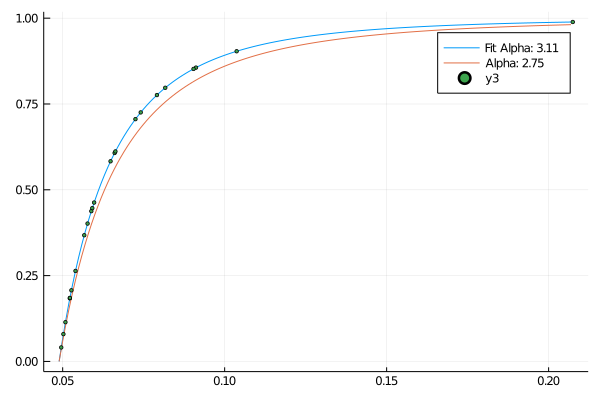

In [605]:
density_plot_fit(v10, gg, aa, :right)

In [526]:
g,_,a,_=fit_alpha(v10, :left)

Fitted alpha stats left side is:
alpha ------> 2.1327948300577444
gamma ------> 0.04504279600570612
Asq --------> 0.4173053234040225
n ----------> 38
% of N: ----> 17.9%


(0.04504279600570612, 0.4173053234040225, 2.1327948300577444, 38)

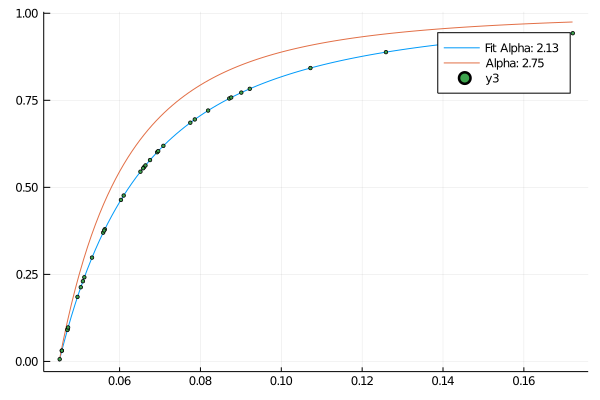

In [603]:
density_plot_fit(v10,g,a, :left)